In [3]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams.update({'font.size': 18})

### Open model output and tracer budget outputs with 1000 salinity bins

In [8]:
ds_10min.AKs

<xarray.DataArray 'AKs' (ocean_time: 720, s_w: 31, eta_rho: 602, xi_rho: 677)>
dask.array<concatenate, shape=(720, 31, 602, 677), dtype=float32, chunksize=(1, 31, 602, 677), chunktype=numpy.ndarray>
Coordinates:
  * s_w         (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(602, 677), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(602, 677), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-06-20
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 670 671 672 673 674 675 676
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 595 596 597 598 599 600 601
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 602, 677), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(31, 602, 677), meta=np.ndarray>
Attributes:
    long_name:  salinity vertical diffusion coefficient
    units:      meter2 second-1
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   face
    field:      AKs, scalar, series

In [4]:
paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00001.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00002.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00003.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00004.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00005.nc',
        ]
paths1 = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00001.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00002.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00003.nc',
        ]

ds_10min = xroms.open_mfnetcdf(paths, 
                                chunks = {'ocean_time':1})
ds_10min, grid_hourly = xroms.roms_dataset(ds_10min, 
                                     Vtransform = None)

xislice=slice(50,250) #note tendencies have x+1 stopping points
etaslice=slice(150,350)

#Open tef, tendency terms, and chi for hourly and 10 min history file frequency
tef_10min_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350_s1000.nc')
chi_10min_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_histogram_10min_xi50250_eta150350_sbin1000.nc')

#2D files
tef = xr.open_dataset('/scratch/user/dylan.schlichting/tef/analysis/2d/tef_nested_10min_xi_50_250_eta_150_350_z.nc')
chi = xr.open_dataset('/scratch/user/dylan.schlichting/tef/analysis/2d/dissipation_histogram_10min_xi50250_eta150350_z.nc')

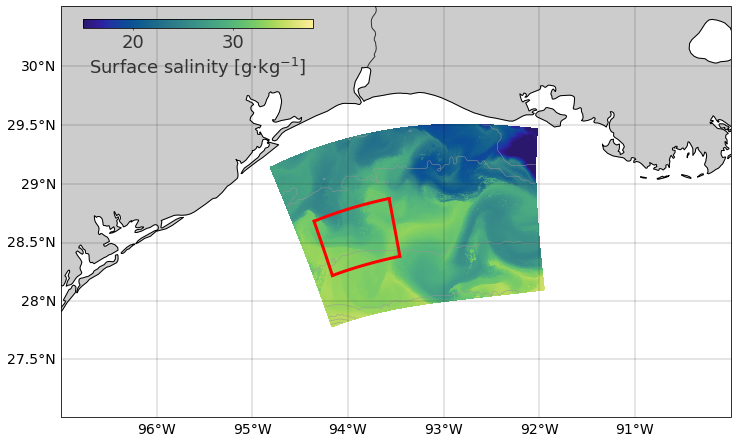

In [4]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

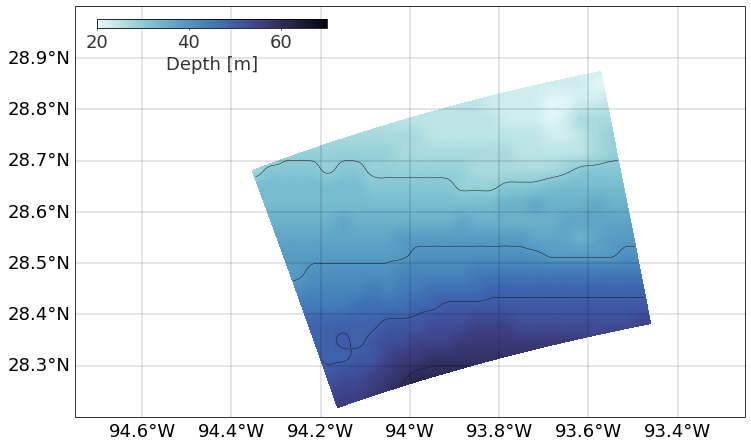

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))

depth = ds_10min.h.isel(xi_rho = xislice, eta_rho = etaslice)
lon_rho = ds_10min.h.isel(xi_rho = xislice, eta_rho = etaslice)['lon_rho'][:].data
lat_rho = ds_10min.h.isel(xi_rho = xislice, eta_rho = etaslice)['lat_rho'][:].data
hlevs = [30, 40, 50, 60]  # isobath contour depths

mappable = ax.pcolormesh(lon_rho, lat_rho, depth, 
                         cmap = cmo.ice_r, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 20, vmax = 70)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-94.75, -93.25, 28.2, 29], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth [m]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

ax.contour(lon_rho, lat_rho, depth, hlevs, colors='0.1', transform=ccrs.PlateCarree(), linewidths=0.5)
# ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

# ax.plot(QN.lon_v.values, QN.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
# ax.plot(QS.lon_v.values, QS.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
# ax.plot(QE.lon_u.values, QE.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
# ax.plot(QW.lon_u.values, QW.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)

# plt.savefig('../figures/CV_location.jpg', dpi = 200)

Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

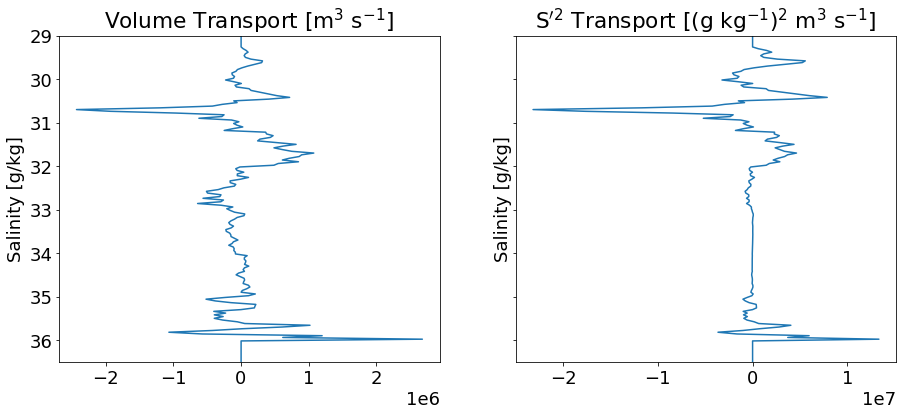

In [6]:
fig, axs = plt.subplots(1,2, figsize = (15,6), sharey = True)

tef_10min_s1000.Qnet.sum('ocean_time').plot(y = 'salt_bin', 
                        ax = axs[0]
                                           )

tef_10min_s1000.Qsvarnet.sum('ocean_time').plot(y = 'salt_bin', 
                        ax = axs[1])


for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()

axs[0].set_title('Volume Transport [m$^3$ s$^{-1}$]')
axs[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')


Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')

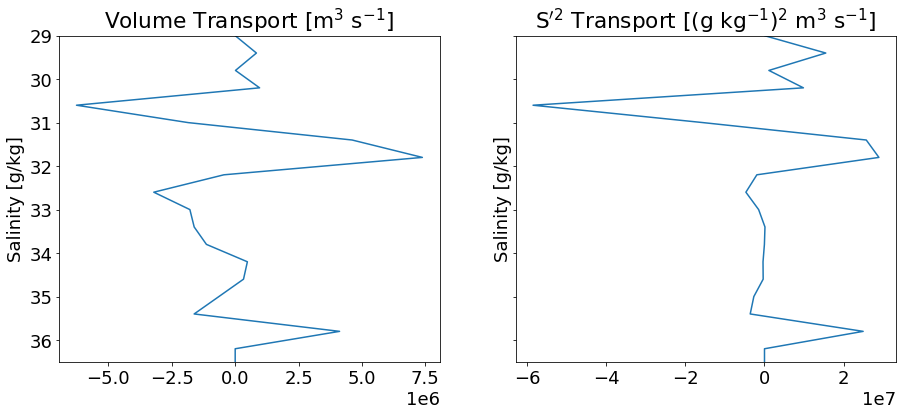

In [7]:
fig, axs = plt.subplots(1,2, figsize = (15,6), sharey = True)

tef.Qnet.sum(['depth_bin','ocean_time']).plot(y = 'salt_bin', 
                        ax = axs[0]
                                           )

tef.Qsvarnet.sum(['depth_bin','ocean_time']).plot(y = 'salt_bin', 
                        ax = axs[1])


for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()

axs[0].set_title('Volume Transport [m$^3$ s$^{-1}$]')
axs[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')


Text(0.5, 1.0, 'Bulk S$^\\prime{^2}$ Transport')

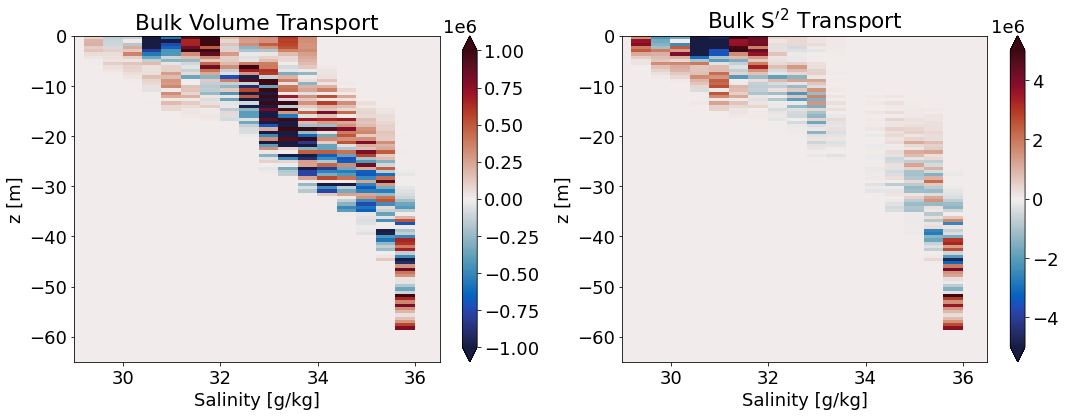

In [31]:
fig, axs = plt.subplots(1,2, figsize = (18,6), )

tef.Qnet.sum('ocean_time').plot(y = 'depth_bin',
                                cmap = cmo.balance,
                                ax = axs[0],
                                vmax = 1e6,
                                cbar_kwargs = {'label': ''}
                                 )

tef.Qsvarnet.sum('ocean_time').plot(y = 'depth_bin', 
                                    cmap = cmo.balance,
                                    ax = axs[1],
                                    vmax = 5e6,
                                    cbar_kwargs = {'label': ''}
                                   )

axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(ylabel = 'z [m]', 
           xlabel = 'Salinity [g/kg]',
           xlim = (29,36.5),
           ylim = (-0, -65)
           )
    ax.invert_yaxis()

axs[0].set_title('Bulk Volume Transport')
axs[1].set_title('Bulk S$^\prime{^2}$ Transport')


#### Notes on this plot: we can see that the strongest exchange flow happens at the deepest depths of the control volume, as expected. Another pattern that emerges is that the flow is more chaotic or multilayered at smaller depths, with the exception of 40-50, where the transport is weakest 

Text(0.5, 1.0, 'Bulk S$^\\prime{^2}$ Dissipation')

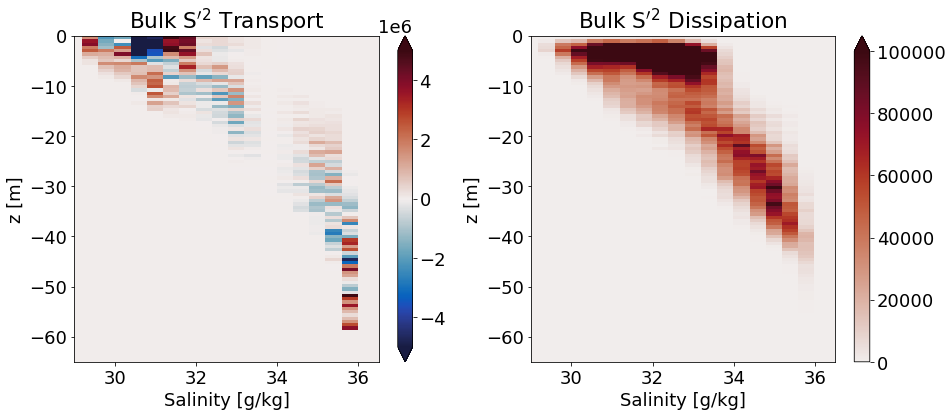

In [43]:
fig, axs = plt.subplots(1,2, figsize = (15,6), )

tef.Qsvarnet.sum('ocean_time').plot(y = 'depth_bin',
                                cmap = cmo.balance,
                                ax = axs[0],
                                vmax = 5e6,
                                cbar_kwargs = {'label': ''}
                                 )

chi.histogram_salt_depth.sum('ocean_time').plot(y = 'depth_bin', 
                                    cmap = cmo.amp,
                                    ax = axs[1],
                                    vmax = 1e5,
                                    cbar_kwargs = {'label': ''}
                                   )

axs[1].set_yticks(np.arange(-60, 6, 10))

for ax in axs.flat:
    ax.set(ylabel = 'z [m]', 
           xlabel = 'Salinity [g/kg]',
           xlim = (29,36.5),
           ylim = (-0, -65)
           )
    ax.invert_yaxis()

axs[0].set_title('Bulk S$^\prime{^2}$ Transport')
axs[1].set_title('Bulk S$^\prime{^2}$ Dissipation')


test = xr.open_dataset('../analysis/Qh_nested_10min_test.nc')

test.sum('ocean_time').plot(cmap = cmo.balance)

In [11]:
saltbins = np.linspace(0,40, 1001)
depthbins = np.linspace(0, 100, 1001)

In [12]:
chi_10min_s1000

<xarray.Dataset>
Dimensions:         (ocean_time: 720, salt_bin: 1000)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-15T00:10:00 ... 2010-...
  * salt_bin        (salt_bin) float64 0.02 0.06 0.1 0.14 ... 39.9 39.94 39.98
Data variables:
    histogram_salt  (ocean_time, salt_bin) float64 ...

In [13]:
tef_10min_s1000.sout.mean().values

array(33.60841893)

Text(0.5, 1.0, 'Exchange Flow Salinities')

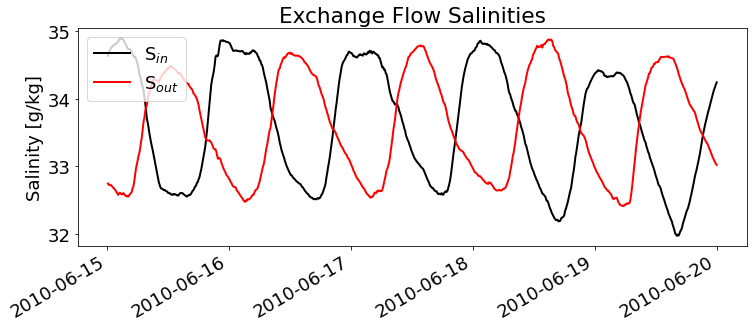

In [14]:
fig = plt.subplots(1,1, figsize = (12,4))

tef_10min_s1000.sin.plot(lw = 2, color = 'k', label = r'S$_{in}$')
tef_10min_s1000.sout.plot(lw = 2, color = 'r', label = r'S$_{out}$')

plt.xlabel('')
plt.ylabel('Salinity [g/kg]')

plt.legend(loc = 2)
plt.title('Exchange Flow Salinities')

#### The signal here is strongly inertial. At the CV latitude, the latitude is approximately 28.6 degrees N. The inertial period at this latitude is approximately 25.3 hours. Let's low pass filter the TEF salinities to see how the residual transport looks.

In [19]:
ntimes = 3*25 #10 minute output so 6 timesteps per hour times 25 hours
win = signal.hanning(ntimes)

sin_lowpass = xr.apply_ufunc(signal.convolve, tef_10min_s1000.sin, kwargs={'in2': win,'mode': 'same'})/sum(win)
sout_lowpass = xr.apply_ufunc(signal.convolve, tef_10min_s1000.sout, kwargs={'in2': win,'mode': 'same'})/sum(win)

<ipython-input-19-54fc421dbfaf>:2: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  win = signal.hanning(ntimes)


In [22]:
xroms.KE

<function xroms.derived.KE(rho0, speed)>

Text(0.5, 1.0, 'Exchange Flow Salinities')

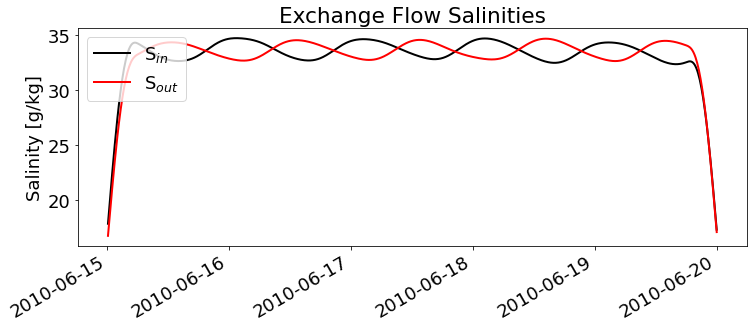

In [20]:
fig = plt.subplots(1,1, figsize = (12,4))

sin_lowpass.plot(lw = 2, color = 'k', label = r'S$_{in}$')
sout_lowpass.plot(lw = 2, color = 'r', label = r'S$_{out}$')

plt.xlabel('')
plt.ylabel('Salinity [g/kg]')

plt.legend(loc = 2)
plt.title('Exchange Flow Salinities')

Text(0, 0.5, 'Sout [g/kg]')

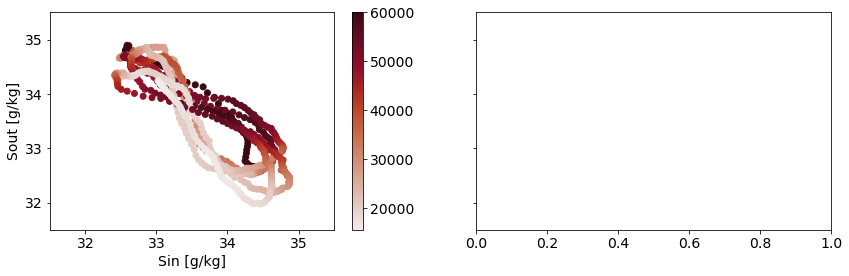

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4), sharey = True)
ax1 = ax[0].scatter(tef_10min_s1000.sout, tef_10min_s1000.sin, 
                    c = chi_10min_s1000.histogram_salt.sum('salt_bin'), 
                    cmap = cmo.amp,
                    vmax = 6E4)
fig.colorbar(ax1, ax = ax[0])

ax[0].set_xlim(31.5, 35.5)
ax[0].set_ylim(31.5, 35.5)
ax[0].set_xlabel('Sin [g/kg]')
ax[0].set_ylabel('Sout [g/kg]')
# ax[0].invert_yaxis()